In [1]:
import pandas as pd
from fastai.vision.all import *

MANIFESTS_DIR = os.path.join(os.path.dirname(os.path.abspath('')), 'floripa-guessr', 'dataset', 'manifests')
TRAIN_CSV = os.path.join(MANIFESTS_DIR, "training_manifest.csv")
VALID_CSV = os.path.join(MANIFESTS_DIR, "validation_manifest.csv")

BATCH_SIZE = 64
IMG_CROP_SIZE = 512
NUM_WORKERS = 16

IMG_CROP_SIZE, BATCH_SIZE, MANIFESTS_DIR, TRAIN_CSV, VALID_CSV

(512,
 64,
 '/lapix/floripa-guessr/dataset/manifests',
 '/lapix/floripa-guessr/dataset/manifests/training_manifest.csv',
 '/lapix/floripa-guessr/dataset/manifests/validation_manifest.csv')

In [2]:
#### build_datablock():
training_dataframe = pd.read_csv(TRAIN_CSV)
validation_dataframe = pd.read_csv(VALID_CSV)

# setup for datablock splitter
training_dataframe['is_validation'] = False
validation_dataframe['is_validation'] = True

dataframe = pd.concat([training_dataframe, validation_dataframe])

print(f"Dataframe shape: {dataframe.shape}")
print(f"Sample files exist: {dataframe['file'].head().apply(os.path.exists).all()}")
print(f"Unique cells: {dataframe['cell'].nunique()}")

class_counts = training_dataframe['cell'].value_counts()
print(f"Most common class: {class_counts.iloc[0]} samples")
print(f"Least common class: {class_counts.iloc[-1]} samples")
print(f"Class imbalance ratio: {class_counts.iloc[0] / class_counts.iloc[-1]:.2f}")

transforms = [
    *aug_transforms(
        size=IMG_CROP_SIZE,
        flip_vert=False,
        max_rotate=15.,
        max_zoom=1.05,
        max_lighting=0.3,
        max_warp=0.,
        p_affine=0.7,
        p_lighting=0.6
    ),
    Normalize.from_stats(*imagenet_stats)
]

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('file'),
    get_y=ColReader('cell'),
    splitter=ColSplitter('is_validation'),
    item_tfms=Resize(IMG_CROP_SIZE, method='squish'),
    batch_tfms=transforms
)

Dataframe shape: (10371, 7)
Sample files exist: True
Unique cells: 30
Most common class: 557 samples
Least common class: 70 samples
Class imbalance ratio: 7.96


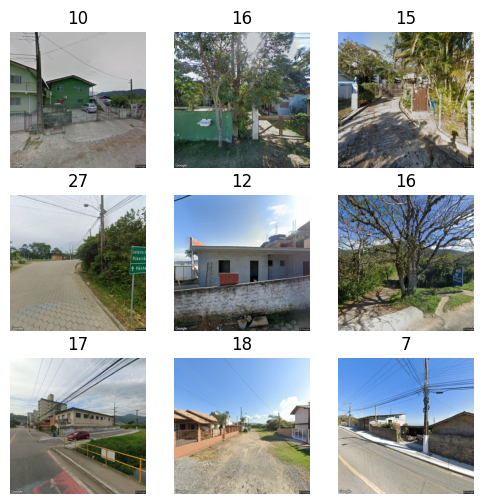

In [3]:
### build_dataloader(datablock, dataframe):
dataloaders = datablock.dataloaders(
    dataframe,
    bs=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle_train=True
)

dataloaders.valid.show_batch(max_n=9, figsize=(6,6))

In [4]:
### build_learner(dataloaders):
learner = vision_learner(
    dataloaders,
    efficientnet_b4,
    metrics=[accuracy, partial(top_k_accuracy, k=3), partial(top_k_accuracy, k=5)],
    loss_func=LabelSmoothingCrossEntropy(),
    cbs=[MixUp(alpha=0.2)]
)

#learner.add_cb(MixUp(alpha=0.4))
#learner.add_cb(CutMix(alpha=1.0))

#lrs = learner.lr_find(
    #start_lr=1e-5,
    #end_lr=1,
    #num_it=200,
    #stop_div=True,
    #show_plot=True,
    #suggest_funcs=(minimum, steep, valley, slide)
#)
# SuggestedLRs(minimum=0.0025118865072727204, steep=0.00478630093857646, valley=0.0007585776038467884, slide=0.03981071710586548)
#print(lrs)
# empirically best learning rate
lr = 0.03981071710586548

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
### train_learner(learner, lr_min, lr_steep):
print("Starting training...")
print("1) training classifier head...\n")
learner.freeze()
learner.fit_one_cycle(
    3, 
    lr_max=lr,
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='best_head'),
        SaveModelCallback(every_epoch=True, fname='head_epoch')
    ]
)
# checkpoint
learner.save('checkpoint-head_training')
learner.export('models/head.pkl')

print("2) fine-tuning entire model...\n")
learner.unfreeze()
learner.fit_one_cycle(
    10, 
    lr_max=slice(lr/10, lr/3),
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='best_finetune'),
        SaveModelCallback(every_epoch=True, fname='finetune_epoch'),
        #EarlyStoppingCallback(monitor='valid_loss', patience=3)
    ]
)
# checkpoint
learner.save('checkpoint-finetune_training')
learner.export('models/finetune.pkl')

print("3) fine-tune with lower learning rate and higher weight decay")
learner.fit_one_cycle(
    6,
    slice(lr/100, lr/10),
    wd=0.1,
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='best_final'),
        SaveModelCallback(every_epoch=True, fname='final_epoch'),
        EarlyStoppingCallback(monitor='valid_loss', patience=3)
    ]
)
# checkpoint
learner.save('checkpoint-final_training')
learner.export('models/final.pkl')

Starting training...
1) training classifier head...



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,3.837898,3.089078,0.127711,0.306506,0.452530,00:51
1,3.118452,3.289716,0.249639,0.479518,0.616386,00:50
2,2.838710,3.032745,0.315181,0.555663,0.680964,00:50


Better model found at epoch 0 with valid_loss value: 3.089078187942505.
Better model found at epoch 2 with valid_loss value: 3.032745122909546.


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

2) fine-tuning entire model...



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.711596,2.541839,0.341687,0.590361,0.706506,01:01
1,2.771868,2.571144,0.312771,0.569157,0.682410,01:01
2,2.749387,2.531420,0.325783,0.579759,0.699759,01:00
3,2.655106,2.341168,0.390843,0.638554,0.761446,01:00
4,2.464324,2.224257,0.438072,0.680964,0.785060,01:00
5,2.246964,2.107169,0.489157,0.719518,0.816867,01:01
6,1.978350,1.935895,0.543133,0.769157,0.860723,01:00
7,1.730757,1.872752,0.565783,0.791807,0.867470,01:01
8,1.567618,1.836061,0.584096,0.796627,0.872289,01:01
9,1.485071,1.821318,0.593253,0.805783,0.874217,01:00


Better model found at epoch 0 with valid_loss value: 2.5418388843536377.
Better model found at epoch 2 with valid_loss value: 2.5314202308654785.
Better model found at epoch 3 with valid_loss value: 2.34116792678833.
Better model found at epoch 4 with valid_loss value: 2.224257469177246.
Better model found at epoch 5 with valid_loss value: 2.1071693897247314.
Better model found at epoch 6 with valid_loss value: 1.9358948469161987.
Better model found at epoch 7 with valid_loss value: 1.8727517127990723.
Better model found at epoch 8 with valid_loss value: 1.8360612392425537.
Better model found at epoch 9 with valid_loss value: 1.8213179111480713.


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

3) fine-tune with lower learning rate and higher weight decay


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.490898,1.820587,0.592289,0.813494,0.876626,01:01
1,1.481520,1.855006,0.575422,0.806265,0.879036,01:01
2,1.440053,1.813016,0.603855,0.799036,0.868916,01:01
3,1.364047,1.799428,0.602892,0.808675,0.878072,01:01
4,1.353151,1.795847,0.610120,0.803374,0.877590,01:01
5,1.334067,1.797928,0.608193,0.802892,0.878072,01:01


Better model found at epoch 0 with valid_loss value: 1.8205865621566772.
Better model found at epoch 2 with valid_loss value: 1.8130156993865967.
Better model found at epoch 3 with valid_loss value: 1.7994277477264404.
Better model found at epoch 4 with valid_loss value: 1.795846700668335.


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

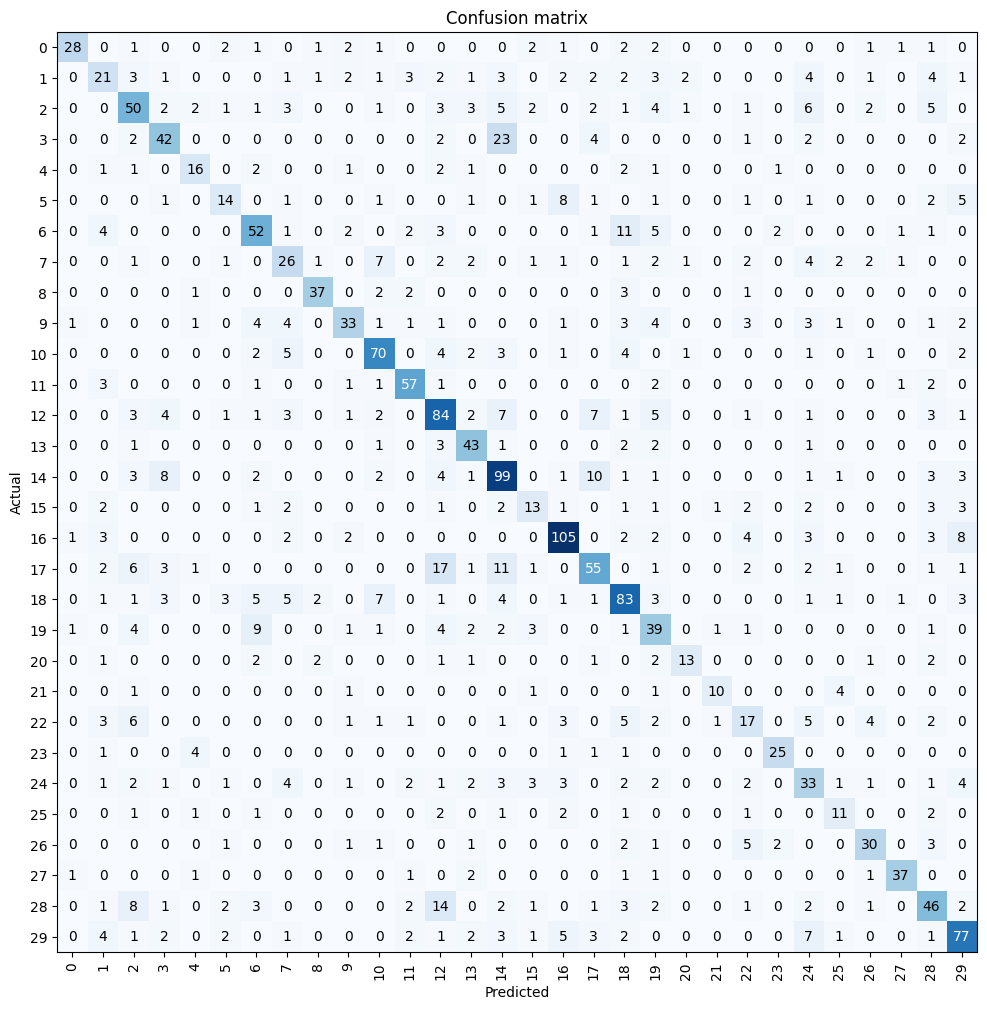

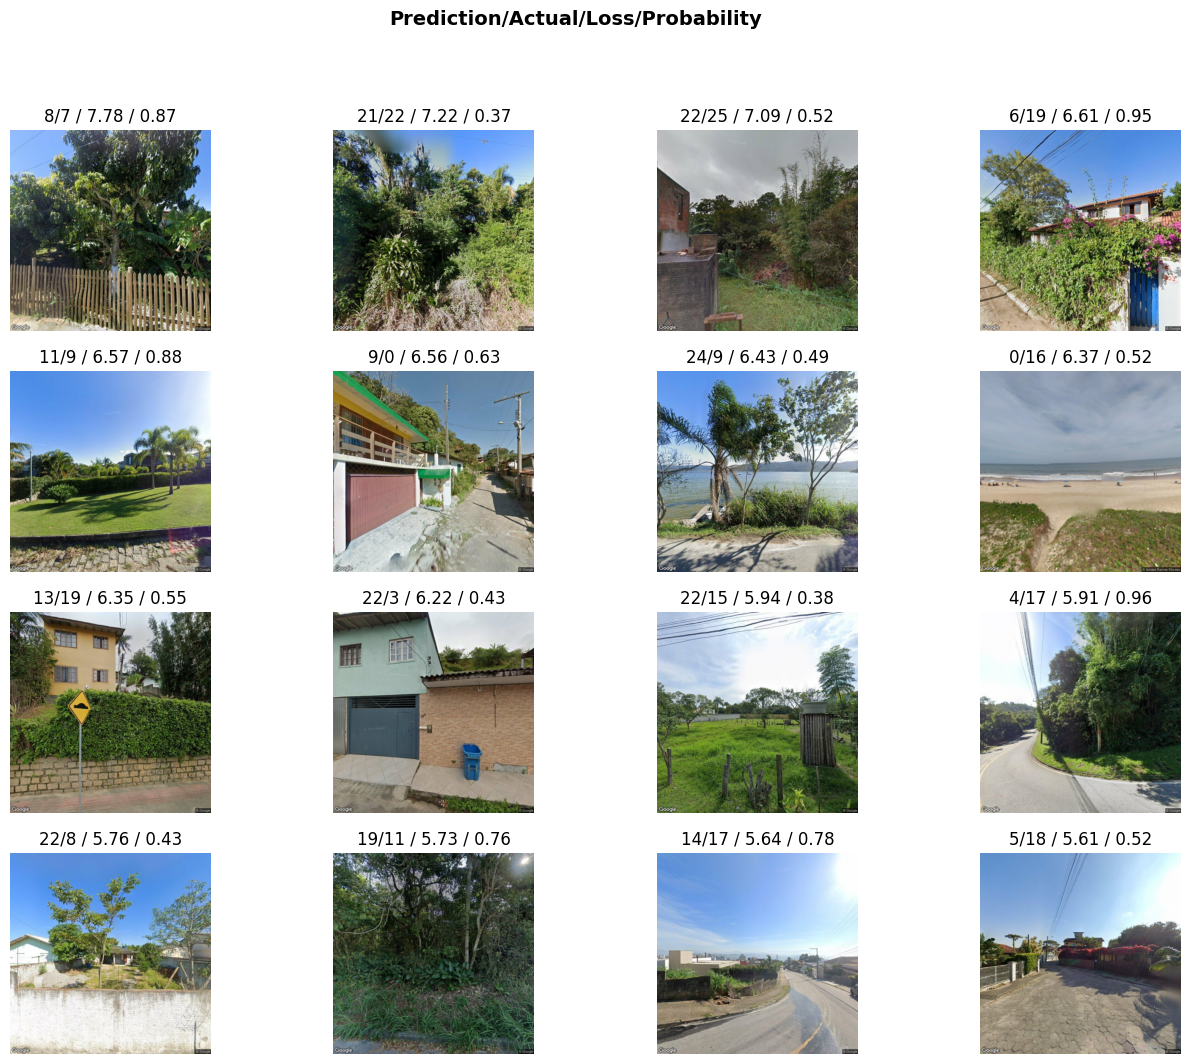

Most Confused Classes:
  3 ↔ 14: 23 misclassifications
  17 ↔ 12: 17 misclassifications
  28 ↔ 12: 14 misclassifications
  6 ↔ 18: 11 misclassifications
  17 ↔ 14: 11 misclassifications
  14 ↔ 17: 10 misclassifications
  19 ↔ 6: 9 misclassifications
  5 ↔ 16: 8 misclassifications
  14 ↔ 3: 8 misclassifications
  16 ↔ 29: 8 misclassifications
  28 ↔ 2: 8 misclassifications
  7 ↔ 10: 7 misclassifications
  12 ↔ 14: 7 misclassifications
  12 ↔ 17: 7 misclassifications
  18 ↔ 10: 7 misclassifications
  29 ↔ 24: 7 misclassifications
  2 ↔ 24: 6 misclassifications
  17 ↔ 2: 6 misclassifications
  22 ↔ 2: 6 misclassifications
  2 ↔ 14: 5 misclassifications
  2 ↔ 28: 5 misclassifications
  5 ↔ 29: 5 misclassifications
  6 ↔ 19: 5 misclassifications
  10 ↔ 7: 5 misclassifications
  12 ↔ 19: 5 misclassifications
  18 ↔ 6: 5 misclassifications
  18 ↔ 7: 5 misclassifications
  22 ↔ 18: 5 misclassifications
  22 ↔ 24: 5 misclassifications
  26 ↔ 22: 5 misclassifications
  29 ↔ 16: 5 misclassificati


Per-Class Accuracies:
  22: 0.327
  1: 0.350
  5: 0.368
  15: 0.371
  7: 0.456
  24: 0.471
  25: 0.478
  20: 0.500
  28: 0.500
  9: 0.516
  17: 0.524
  2: 0.526
  3: 0.538
  21: 0.556
  19: 0.557
  4: 0.571
  0: 0.609
  6: 0.612
  26: 0.638
  18: 0.659
  12: 0.661
  29: 0.670
  14: 0.707
  10: 0.729
  23: 0.758
  16: 0.778
  13: 0.796
  8: 0.804
  27: 0.822
  11: 0.826
Model exported to floripa-guessr.pkl


In [6]:
### show_results(learner):
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12, 10), dpi=100)
plt.show()

interp.plot_top_losses(16, nrows=4, figsize=(16, 12))
plt.show()

most_confused = interp.most_confused(min_val=3)
print("Most Confused Classes:")
for confusion in most_confused:
    print(f"  {confusion[0]} ↔ {confusion[1]}: {confusion[2]} misclassifications")

class_accuracies = {}
preds, targets = learner.get_preds()
pred_classes = preds.argmax(dim=1)

for i, class_name in enumerate(learner.dls.vocab):
    mask = targets == i
    if mask.sum() > 0:
        acc = (pred_classes[mask] == i).float().mean()
        class_accuracies[class_name] = acc.item()

print("\nPer-Class Accuracies:")
sorted_accs = sorted(class_accuracies.items(), key=lambda x: x[1])
for class_name, acc in sorted_accs:
    print(f"  {class_name}: {acc:.3f}")

### execute_pipeline():
# dataframe, datablock = build_datablock()
# dataloaders = build_dataloader(datablock, dataframe)
# model, lr_min, lr_steep = build_learner(dataloaders)
# train_learner(model, lr_min, lr_steep)
# show_results(model)

model_out = "floripa-guessr.pkl"
learner.export(model_out)
print(f"Model exported to {model_out}")